In [1]:
# Replace with your actual repo URL
!git clone https://github.com/VassilisK2001/Grecotel-Project.git

Cloning into 'Grecotel-Project'...
remote: Enumerating objects: 125, done.
remote: Total 125 (delta 0), reused 0 (delta 0), pack-reused 125 (from 1)
Receiving objects: 100% (125/125), 36.52 MiB | 15.46 MiB/s, done.
Resolving deltas: 100% (49/49), done.
Updating files: 100% (44/44), done.
Filtering content: 100% (2/2), 255.43 MiB | 11.04 MiB/s, done.


In [2]:
# ==========================================
# 1. INSTALL DEPENDENCIES
# ==========================================
%pip install -q transformers datasets scikit-learn accelerate seaborn iterative-stratification

In [ ]:
import os
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from ast import literal_eval
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import f1_score, classification_report
from iterstrat.ml_stratifiers import MultilabelStratifiedShuffleSplit
from torch.utils.data import Dataset
from transformers import (
    LongformerTokenizer, 
    LongformerForSequenceClassification, 
    TrainingArguments, 
    Trainer,
    DataCollatorWithPadding
)

In [4]:
# ==========================================
# 2. CONFIGURATION & DATA PREPARATION
# ==========================================
# Set file path
DATA_FILE = "Grecotel-Project/absa/labeled_hotel_reviews_full.json" 

def load_and_preprocess_data(filepath):
    print("Loading and preprocessing data...")
    df = pd.read_json(filepath)
    
    # 1. Create Combined Label (Aspect + Sentiment)
    # Example: "FOOD" + "positive" -> "FOOD_positive"
    df['combined_label'] = df['aspect'] + '_' + df['sentiment']
    
    # 2. Remove rows with missing aspects if any
    df = df.dropna(subset=['aspect'])

    # 3. Pivot to Wide Format (One row per review, list of labels)
    grouped = df.groupby(['id', 'review_text'])['combined_label'].apply(list).reset_index()
    
    # 4. Multi-Hot Encoding
    mlb = MultiLabelBinarizer()
    binary_labels = mlb.fit_transform(grouped['combined_label'])
    
    # Create final dataframe
    final_df = grouped[['review_text']].copy()
    final_df['labels'] = list(binary_labels)
    
    print(f"Processed {len(final_df)} unique reviews.")
    print(f"Detected {len(mlb.classes_)} unique classes: {mlb.classes_}")
    
    return final_df, mlb

In [5]:
# Load Data
df, mlb = load_and_preprocess_data(DATA_FILE)

Loading and preprocessing data...
Processed 11961 unique reviews.
Detected 16 unique classes: ['CLEANLINESS_negative' 'CLEANLINESS_positive' 'COMFORT_negative'
 'COMFORT_positive' 'FACILITIES_negative' 'FACILITIES_positive'
 'FOOD_negative' 'FOOD_positive' 'LOCATION_negative' 'LOCATION_positive'
 'ROOM_negative' 'ROOM_positive' 'SERVICE_negative' 'SERVICE_positive'
 'VALUE_FOR_MONEY_negative' 'VALUE_FOR_MONEY_positive']


In [6]:
# ==========================================
# 3. STRATIFIED SPLIT (Train / Val / Test)
# ==========================================
print("\nSplitting dataset (80% Train, 10% Val, 10% Test)...")

X = df['review_text'].to_numpy()
y = np.array(df['labels'].tolist())

# Split 1: Separate Test Set (10%)
msss_test = MultilabelStratifiedShuffleSplit(n_splits=1, test_size=0.1, random_state=42)
for train_index, test_index in msss_test.split(X, y):
    X_train_val, X_test = X[train_index], X[test_index]
    y_train_val, y_test = y[train_index], y[test_index]

# Split 2: Separate Train (80%) and Val (10%) from the remaining 90%
# 0.11 of 90% is approx 10% of total
msss_val = MultilabelStratifiedShuffleSplit(n_splits=1, test_size=0.11, random_state=42)
for train_index, val_index in msss_val.split(X_train_val, y_train_val):
    X_train, X_val = X_train_val[train_index], X_train_val[val_index]
    y_train, y_val = y_train_val[train_index], y_train_val[val_index]

# Helper to convert back to DataFrame
def to_df(texts, labels):
    return pd.DataFrame({'review_text': texts, 'labels': list(labels)})

train_df = to_df(X_train, y_train)
val_df = to_df(X_val, y_val)
test_df = to_df(X_test, y_test)

print(f"Train Size: {len(train_df)} | Val Size: {len(val_df)} | Test Size: {len(test_df)}")


Splitting dataset (80% Train, 10% Val, 10% Test)...
Train Size: 9575 | Val Size: 1182 | Test Size: 1204


In [7]:
# ==========================================
# 4. CUSTOM DATASET & TOKENIZER
# ==========================================
class LongformerABSA_Dataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_len=4096):
        self.data = dataframe
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        text = str(self.data.iloc[index]['review_text'])
        labels = self.data.iloc[index]['labels']

        # Tokenize
        encoding = self.tokenizer(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )

        input_ids = encoding['input_ids'].flatten()
        attention_mask = encoding['attention_mask'].flatten()

        # --- GLOBAL ATTENTION MASK (CRITICAL FOR LONGFORMER) ---
        # 1 = Global Attention (Look at everything), 0 = Local Attention
        # We put Global Attention ONLY on the [CLS] token (first token)
        global_attention_mask = torch.zeros_like(input_ids)
        global_attention_mask[0] = 1 

        return {
            'input_ids': input_ids,
            'attention_mask': attention_mask,
            'global_attention_mask': global_attention_mask, 
            'labels': torch.tensor(labels, dtype=torch.float)
        }

# Initialize Tokenizer
print("\nInitializing Longformer Tokenizer...")
model_name = 'allenai/longformer-base-4096'
tokenizer = LongformerTokenizer.from_pretrained(model_name)

# Create Datasets
train_dataset = LongformerABSA_Dataset(train_df, tokenizer)
val_dataset = LongformerABSA_Dataset(val_df, tokenizer)
test_dataset = LongformerABSA_Dataset(test_df, tokenizer)


Initializing Longformer Tokenizer...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:104: UserWarning: 
Error while fetching `HF_TOKEN` secret value from your vault: 'Requesting secret HF_TOKEN timed out. Secrets can only be fetched when running from the Colab UI.'.
You are not authenticated with the Hugging Face Hub in this notebook.
If the error persists, please let us know by opening an issue on GitHub (https://github.com/huggingface/huggingface_hub/issues/new).
  warnings.warn(


vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

config.json:   0%|          | 0.00/694 [00:00<?, ?B/s]

In [8]:
# ==========================================
# 5. MODEL SETUP & METRICS
# ==========================================
# Create ID maps
id2label = {i: label for i, label in enumerate(mlb.classes_)}
label2id = {label: i for i, label in enumerate(mlb.classes_)}

print("Loading Model...")
model = LongformerForSequenceClassification.from_pretrained(
    model_name,
    num_labels=len(mlb.classes_),
    problem_type="multi_label_classification",
    id2label=id2label,
    label2id=label2id
)

# Move to GPU if available
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

def compute_metrics(p):
    predictions, labels = p
    # Sigmoid to get 0-1 probabilities
    sigmoid = torch.nn.Sigmoid()
    probs = sigmoid(torch.Tensor(predictions))
    # Threshold at 0.5
    y_pred = np.zeros(probs.shape)
    y_pred[probs >= 0.5] = 1
    
    f1_micro = f1_score(y_true=labels, y_pred=y_pred, average='micro')
    return {'f1_micro': f1_micro}

Loading Model...


pytorch_model.bin:   0%|          | 0.00/597M [00:00<?, ?B/s]

Some weights of LongformerForSequenceClassification were not initialized from the model checkpoint at allenai/longformer-base-4096 and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


model.safetensors:   0%|          | 0.00/597M [00:00<?, ?B/s]

In [ ]:
# ==========================================
# 6. TRAINING (A100 OPTIMIZED)
# ==========================================

training_args = TrainingArguments(
    output_dir="/content/longformer_output",
    
    # --- A100 POWER SETTINGS ---
    per_device_train_batch_size=4,       # INCREASED: A100 can handle ~4 samples (w/ checkpointing)
    per_device_eval_batch_size=4,        # INCREASED: Faster evaluation
    gradient_accumulation_steps=4,       # DECREASED: 4 batch * 4 accum = 16 effective batch size
    
    gradient_checkpointing=True,         # KEEP TRUE: Still needed for Longformer with 4096 tokens
    fp16=False,                          # Turn OFF fp16
    bf16=True,                           # Turn ON bf16 (A100 specific feature - more stable)
    
    dataloader_num_workers=4,            # Feed data faster to the GPU
    # ---------------------------

    # Best Model Strategy (Unchanged)
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="f1_micro",
    save_total_limit=2,

    num_train_epochs=5,
    learning_rate=3e-5, 
    warmup_ratio=0.1,
    logging_steps=50,
    report_to="none"
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

print("\nStarting Training on A100...")
trainer.train()

trainer.save_model("/content/longformer_output")

/tmp/ipython-input-2606432086.py:34: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(



Starting Training on A100...


Epoch,Training Loss,Validation Loss,F1 Micro
1,0.312900,0.296006,0.805758
2,0.253000,0.245450,0.834757
3,0.202300,0.225245,0.846290
4,0.176600,0.216169,0.853423
5,0.152700,0.213790,0.859296


TrainOutput(global_step=2995, training_loss=0.239800873344052, metrics={'train_runtime': 9987.3628, 'train_samples_per_second': 4.794, 'train_steps_per_second': 0.3, 'total_flos': 1.25799750647808e+17, 'train_loss': 0.239800873344052, 'epoch': 5.0})

In [14]:
import shutil
import os

# 1. Define the folder you want to download
# (Make sure this matches the 'output_dir' you used in your TrainingArguments)
folder_to_download = "/content/longformer_output" 

# 2. Define the output zip filename (without .zip extension)
zip_filename = "/content/model_backup"

print(f"Zipping folder: {folder_to_download} ...")

# 3. Create the Zip file
shutil.make_archive(zip_filename, 'zip', folder_to_download)

print(f"Success! Created: {zip_filename}.zip")
print(f"File size: {os.path.getsize(zip_filename + '.zip') / (1024*1024):.2f} MB")

Zipping folder: /content/longformer_output ...
Success! Created: /content/model_backup.zip
File size: 2792.62 MB


In [18]:
import requests
import os

# 1. Define file path
file_path = "/content/model_backup.zip"

def upload_to_gofile(path):
    print(f"🚀 Uploading {path} to Gofile.io...")
    print("This can take 2-4 minutes depending on Google's speed. Please wait...")
    
    try:
        # A. Get the best server for upload
        server_request = requests.get("https://api.gofile.io/servers")
        server_data = server_request.json()
        
        if server_data['status'] != 'ok':
            return f"Error getting server: {server_data}"
            
        server = server_data['data']['servers'][0]['name']
        print(f"Connected to server: {server}")

        # B. Upload the file
        with open(path, "rb") as f:
            upload_url = f"https://{server}.gofile.io/uploadFile"
            response = requests.post(upload_url, files={'file': f}).json()
            
        if response['status'] == 'ok':
            return response['data']['downloadPage']
        else:
            return f"Upload Failed: {response}"
            
    except Exception as e:
        return f"Error: {e}"

# 2. Run and Print Link
if os.path.exists(file_path):
    link = upload_to_gofile(file_path)
    print("\n" + "="*50)
    print("✅ DOWNLOAD LINK IS HERE:")
    print(link)
    print("="*50)
else:
    print("❌ Error: /content/model_backup.zip does not exist. Did you run the zip step?")

🚀 Uploading /content/model_backup.zip to Gofile.io...
This can take 2-4 minutes depending on Google's speed. Please wait...
Connected to server: store4

✅ DOWNLOAD LINK IS HERE:
https://gofile.io/d/y8vpsw


In [19]:
# ==========================================
# 7. EVALUATION ON TEST SET
# ==========================================
print("\nRunning Evaluation on Test Set...")

predictions_output = trainer.predict(test_dataset)
raw_logits = predictions_output.predictions
true_labels = predictions_output.label_ids

# Convert Logits -> Probs -> Binary Predictions
probs = torch.sigmoid(torch.tensor(raw_logits)).numpy()
y_pred = (probs >= 0.5).astype(int)

# Generate Report
report = classification_report(
    true_labels, 
    y_pred, 
    target_names=mlb.classes_, 
    zero_division=0
)
print("\n--- CLASSIFICATION REPORT ---")
print(report)


Running Evaluation on Test Set...



--- CLASSIFICATION REPORT ---
                          precision    recall  f1-score   support

    CLEANLINESS_negative       0.77      0.60      0.67       141
    CLEANLINESS_positive       0.90      0.93      0.91       399
        COMFORT_negative       0.74      0.68      0.70       210
        COMFORT_positive       0.82      0.71      0.76       381
     FACILITIES_negative       0.76      0.70      0.73       211
     FACILITIES_positive       0.85      0.89      0.87       638
           FOOD_negative       0.82      0.77      0.79       145
           FOOD_positive       0.96      0.97      0.97       861
       LOCATION_negative       0.70      0.56      0.63       110
       LOCATION_positive       0.89      0.92      0.91       735
           ROOM_negative       0.82      0.80      0.81       186
           ROOM_positive       0.80      0.88      0.84       468
        SERVICE_negative       0.82      0.82      0.82       174
        SERVICE_positive       0.97      0.9


Generating Co-occurrence Heatmap...


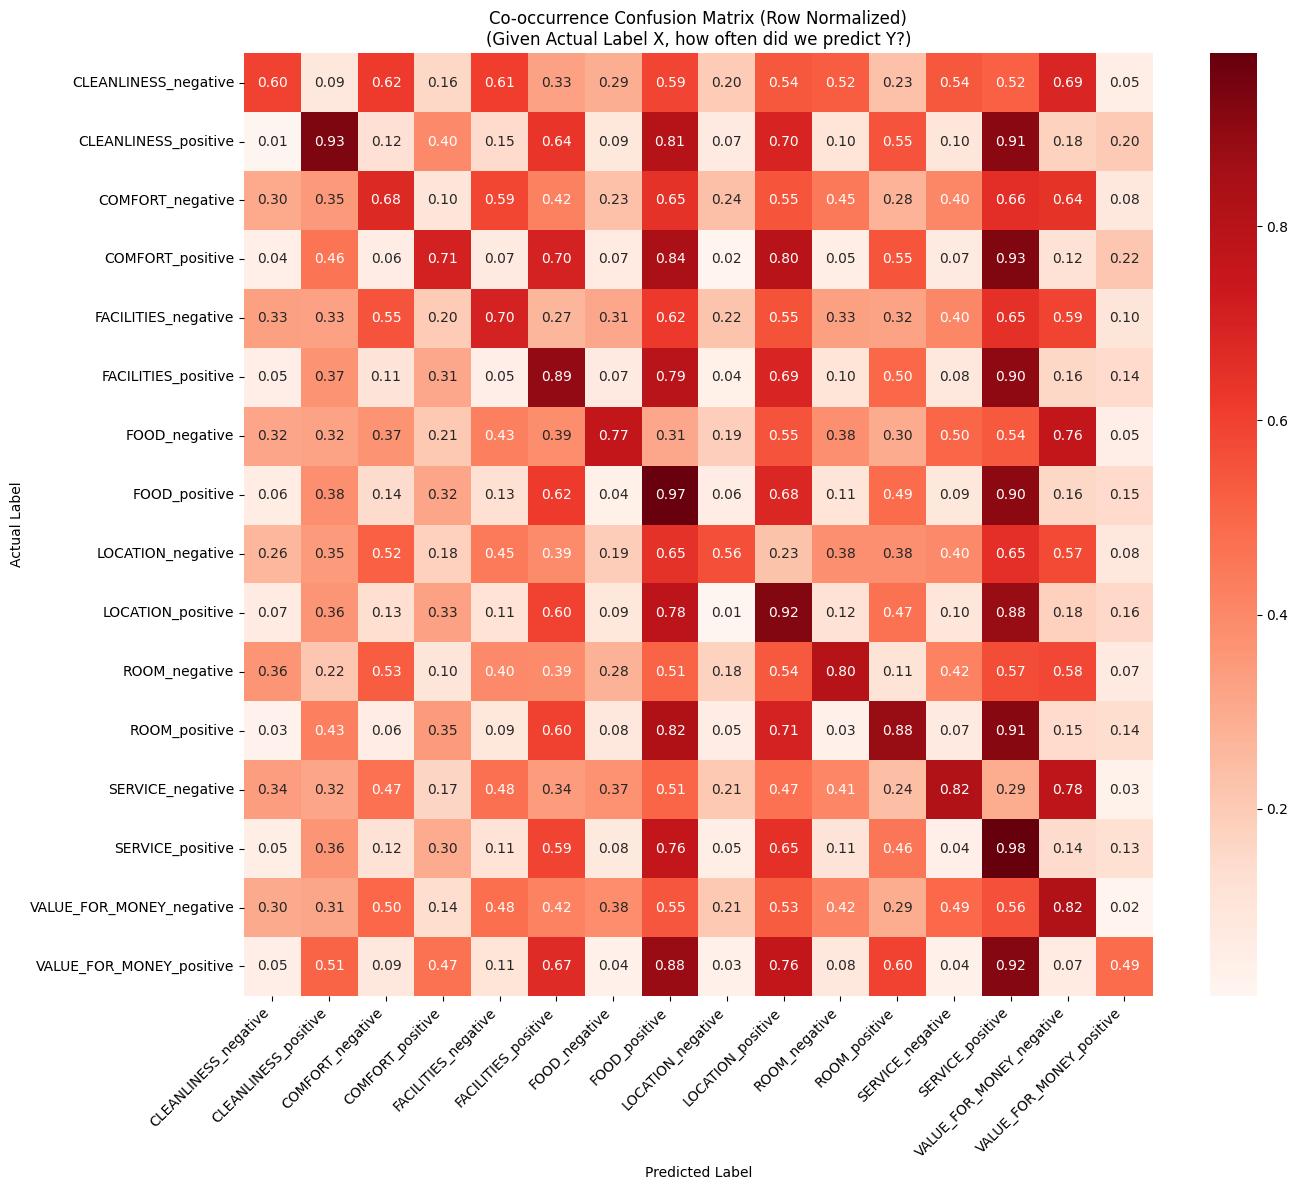

In [20]:
# ==========================================
# 8. PLOT CO-OCCURRENCE HEATMAP
# ==========================================
print("\nGenerating Co-occurrence Heatmap...")

# Calculate intersection: (Actual Label) vs (Predicted Label)
confusion_cooccurrence = np.dot(true_labels.T, y_pred)

# Normalize by row sum (Actual count) to get percentages
row_sums = true_labels.sum(axis=0)
row_sums[row_sums == 0] = 1 # avoid div by zero
norm_conf_matrix = confusion_cooccurrence / row_sums[:, None]

plt.figure(figsize=(14, 12))
sns.heatmap(
    norm_conf_matrix, 
    annot=True, 
    fmt='.2f', 
    cmap='Reds',
    xticklabels=mlb.classes_,
    yticklabels=mlb.classes_
)
plt.title("Co-occurrence Confusion Matrix (Row Normalized)\n(Given Actual Label X, how often did we predict Y?)")
plt.xlabel("Predicted Label")
plt.ylabel("Actual Label")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [23]:

class AspectSentimentAnalyzer:
    def __init__(self, model_path):
        """
        Load the model and tokenizer once when the class is initialized.
        """
        print(f"Loading model from {model_path}...")
        self.tokenizer = LongformerTokenizer.from_pretrained('allenai/longformer-base-4096')
        self.model = LongformerForSequenceClassification.from_pretrained(model_path)
        self.model.eval()  # Set to evaluation mode
        
        # Define Custom Thresholds to fix your "Weaknesses"
        # Standard is 0.5. We lower it for 'Recall' and raise it for 'Precision'.
        self.thresholds = {
            'VALUE_FOR_MONEY_positive': 0.30,  # Lowered to catch more "Value" comments
            'VALUE_FOR_MONEY_negative': 0.30,
            'LOCATION_negative': 0.35,         # Lowered to catch location complaints
            'default': 0.50                    # Standard for everything else (Service, Food, etc.)
        }

    def predict(self, text):
        """
        Analyzes a single review and returns active labels.
        """
        # 1. Tokenize (Dynamic Padding for CPU speed)
        # We do NOT use padding='max_length' here to keep it fast
        inputs = self.tokenizer(
            text, 
            return_tensors="pt", 
            truncation=True, 
            max_length=4096
        )

        # 2. Create Global Attention Mask
        # (Longformer needs to know which token is global. usually [CLS] at index 0)
        global_attention_mask = torch.zeros_like(inputs["input_ids"])
        global_attention_mask[:, 0] = 1
        inputs["global_attention_mask"] = global_attention_mask

        # 3. Inference
        with torch.no_grad():
            outputs = self.model(**inputs)
            logits = outputs.logits
            
        # 4. Convert Logits to Probabilities (Sigmoid)
        probs = torch.sigmoid(logits).numpy()[0]
        
        # 5. Apply Custom Thresholds
        results = {}
        id2label = self.model.config.id2label
        
        for idx, score in enumerate(probs):
            label_name = id2label[idx]
            
            # Determine which threshold to use
            threshold = self.thresholds.get(label_name, self.thresholds['default'])
            
            # If score is higher than that label's specific threshold, keep it
            if score > threshold:
                results[label_name] = float(score)
        
        return results

# ==========================================
# HOW TO USE IT
# ==========================================

# 1. Initialize (Run this once)
# Ensure this points to your unzipped folder
model_path = "/content/longformer_output" 
analyzer = AspectSentimentAnalyzer(model_path)

# 2. Test a sample review
sample_review = """
The food was absolutely delicious and the staff was very friendly.
However, I felt it was a bit expensive for what we got, and the location was hard to find.
"""

print(f"\nReview: {sample_review.strip()}\n")
predictions = analyzer.predict(sample_review)

print("Detected Sentiments:")
for label, score in predictions.items():
    print(f"- {label}: {score:.4f}")

Loading model from /content/longformer_output...


Input ids are automatically padded to be a multiple of `config.attention_window`: 512



Review: The food was absolutely delicious and the staff was very friendly.
However, I felt it was a bit expensive for what we got, and the location was hard to find.

Detected Sentiments:
- FOOD_positive: 0.8865
- LOCATION_negative: 0.8496
- SERVICE_positive: 0.9745
- VALUE_FOR_MONEY_negative: 0.5907
